# Numerical results

### Load packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from scipy.io import loadmat

import time
import h5py
import os

from functions_2D_FVM_SWE import *

plt.rc('font', size=14)  # Set default font size for all text
plt.rc('axes', titlesize=16)  # Set default size for axes titles
plt.rc('axes', labelsize=16)  # Set default size for axis labels

# 1D Dam-break problem

In [51]:
# Load the .mat file
mat_data = loadmat('data/dambreakdata.mat')

h_sol = mat_data['h']
u_sol = mat_data['u']

h_sol = np.array(h_sol[0, :])
u_sol = np.array(u_sol[0, :])

# Load the numerical solution
mat_data = loadmat('data/1D-dam-break-verification.mat')

q = mat_data['q'] 
x = mat_data['x']

h_num = q[0, :]
hu_num = q[1, :]

# Initial conditions
N = 200 # Number of grid points
L = 50 # Length of the domain
x = np.linspace(0, L, N)

# Initial conditions
g = 9.81

hl = 3.5
hr = 1.25
h = np.where(x < 20, hl, hr)


In [52]:
if 0:    
    N = 1000 # Number of grid points
    L = 50 # Length of the domain
    x = np.linspace(0, L, N)

    # Initial conditions
    g = 9.81

    hl = 3.5
    hr = 1.25
    h = np.where(x < 20, hl, hr)


    # Plot initial conditions
    plt.figure(figsize=(10, 6))

    plt.plot(x, h)
    plt.xlabel('Distance x (m)')
    plt.ylabel('Water height h (m)')
    plt.title('Initial conditions for the water height h (m)')
    plt.grid()

    if 0:
        plt.savefig('plots/dam_break_initial_conditions.pdf', format='pdf')

    plt.show()


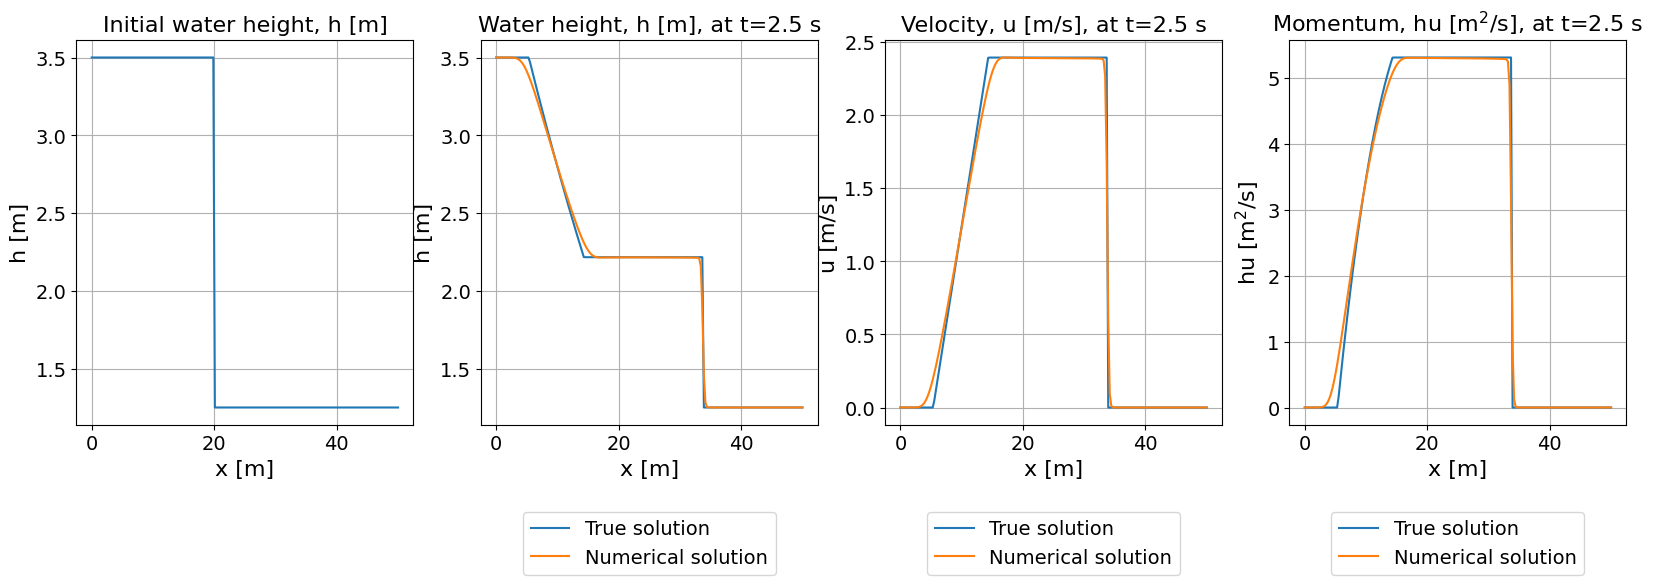

In [61]:
save = 1

# Plot the numerical solution
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.plot(x, h)
plt.xlabel('x [m]')
plt.ylabel('h [m]')
plt.grid()
plt.title('Initial water height, h [m]')

plt.subplot(1, 4, 2)
plt.plot(x, h_sol, label='True solution')
plt.plot(x, h_num, label='Numerical solution')
plt.xlabel('x [m]')
plt.ylabel('h [m]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))
plt.grid()
plt.title('Water height, h [m], at t=2.5 s')

plt.subplot(1, 4, 3)
plt.plot(x, u_sol, label='True solution')
plt.plot(x, hu_num/h_num, label='Numerical solution')
plt.xlabel('x [m]')
plt.ylabel('u [m/s]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))
plt.grid()
plt.title('Velocity, u [m/s], at t=2.5 s')

plt.subplot(1, 4, 4)
plt.plot(x, u_sol*h_sol, label='True solution')
plt.plot(x, hu_num, label='Numerical solution')
plt.xlabel('x [m]')
plt.ylabel(r'hu [m$^2$/s]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))
plt.grid()
plt.title(r'Momentum, hu [m$^2/$s], at t=2.5 s')

# Save figure
if save:
    plt.savefig('plots/sol_1D_val.pdf', format='pdf', bbox_inches='tight')

plt.show()


# Toro test cases

In [43]:
# FLUX CHOICE
# 1--> Godunov method with exact Rieamnn problem
# 2--> Lax-Friedrichs
# 3--> Lax-Wendroff
# 4--> FORCE
# 5--> HLL

save = 1

## Plotting functions

def plot_initial_data(x, h, u, save, filename):

    # Plot the initial data
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(x, h)
    plt.grid()
    plt.ylabel('h [m]')
    plt.xlabel('x [m]')
    plt.title('Initial water height, h [m]')

    plt.subplot(1, 2, 2)
    plt.plot(x, u)
    plt.grid()
    plt.ylabel('u [m/s]')
    plt.xlabel('x [m]')
    plt.title('Initial velocity, u [m/s]')

    plt.tight_layout()
    
    # Save figure
    if save:
        plt.savefig(filename, format='pdf')

    plt.show()

def plot_final_data(xc, xexact, h_GOD, h_LF, h_LW, h_FORCE, h_HLL, hexact, u_GOD, u_LF, u_LW, u_FORCE, u_HLL, uexact, tend, save, markersize, filename):
    # Plot the final data
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    if h_GOD is not None:
        plt.plot(xc[0,:], h_GOD[0,:], 'o', markersize = markersize, label='Godunov') # circle
    if h_LF is not None:
        plt.plot(xc[0,:], h_LF[0,:], 's', markersize = markersize, label='LF') # square
    if h_LW is not None:
        plt.plot(xc[0,:], h_LW[0,:], 'd', markersize = markersize, label='LW') # diamond
    if h_FORCE is not None:
        plt.plot(xc[0,:], h_FORCE[0,:], '^', markersize = markersize, label='FORCE') # triangle
    if h_HLL is not None:
        plt.plot(xc[0,:], h_HLL[0,:], 'x', markersize = markersize, label='HLL') # cross 
        
    plt.plot(xexact[0, :], hexact[0, :], label='True solution')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))
    plt.grid()
    plt.ylabel('h [m]')
    plt.xlabel('x [m]')
    plt.title(f'Water height, h [m], at t = {tend} s')

    plt.subplot(1, 2, 2)
    if u_GOD is not None:
        plt.plot(xc[0,:], u_GOD[0,:], 'o', markersize = markersize, label='Godunov') # circle
    if u_LF is not None:
        plt.plot(xc[0,:], u_LF[0,:], 's', markersize = markersize, label='LF') # square
    if u_LW is not None:
        plt.plot(xc[0,:], u_LW[0,:], 'd', markersize = markersize, label='LW') # diamond
    if u_FORCE is not None:
        plt.plot(xc[0,:], u_FORCE[0,:], '^', markersize = markersize, label='FORCE') # triangle
    if u_HLL is not None:
        plt.plot(xc[0,:], u_HLL[0,:], 'x', markersize = markersize, label='HLL') # cross

    plt.plot(xexact[0, :], uexact[0, :], label='True solution')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))
    plt.grid()
    plt.ylabel('u [m/s]')
    plt.xlabel('x [m]')
    plt.title(f'Velocity, u [m/s], at t = {tend} s')

    # Save figure
    if save:
        plt.savefig(filename, format='pdf', bbox_inches='tight')

    plt.show()

## Test 1

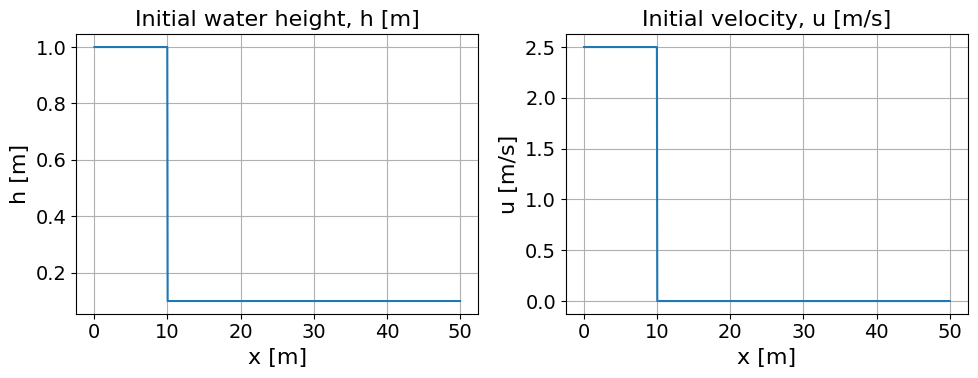

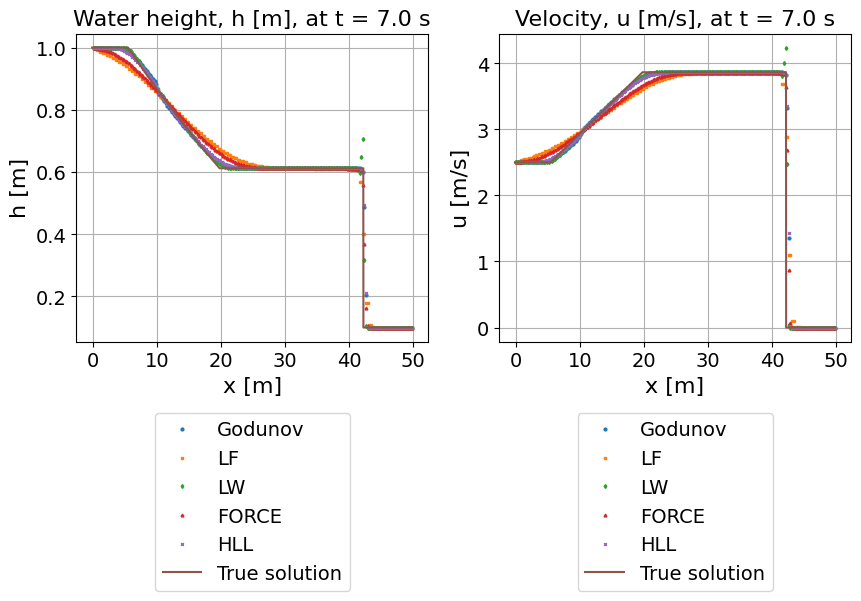

In [44]:
# Physical parameters
xL = 0
xR = 50
t = 0
tend = 7.0

# Numerical parameters
Nx = 1000 # the number of the cell-centers
dx = (xR - xL) / Nx  # distance between the mesh points
x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)

# Initial conditions
h = np.zeros(Nx)
u = np.zeros(Nx)
hL = 1.0
hR = 0.1
uL = 2.5
uR = 0.0
x0 = 10.0

# Define initial water height and velocity
h = np.where(x < x0, hL, hR)           
u = np.where(x < x0, uL, uR)

filename = 'plots/toro_test1_initial.pdf'
plot_initial_data(x, h, u, save, filename)

# Import numerical and true solution from Matlab
mat_data = loadmat('data/torotest1flux1.mat')
xc = mat_data['xc']
h_GOD = mat_data['h']
u_GOD = mat_data['u']
xexact = mat_data['xexact']
hexact = mat_data['hexact']
uexact = mat_data['uexact']

# Load other numerical solutions
mat_data = loadmat('data/torotest1flux2.mat')
h_LF = mat_data['h']
u_LF = mat_data['u']

mat_data = loadmat('data/torotest1flux3.mat')
h_LW = mat_data['h']
u_LW = mat_data['u']

mat_data = loadmat('data/torotest1flux4.mat')
h_FORCE = mat_data['h']
u_FORCE = mat_data['u']

mat_data = loadmat('data/torotest1flux5.mat')
h_HLL = mat_data['h']
u_HLL = mat_data['u']

mat_data = loadmat('data/torotest1flux6.mat')
h_FS = mat_data['h']
u_FS = mat_data['u']

filename = 'plots/toro_test1_final.pdf'
plot_final_data(xc, xexact, h_GOD, h_LF, h_LW, h_FORCE, h_HLL, hexact, u_GOD, u_LF, u_LW, u_FORCE, u_HLL, uexact, tend, save, 2, filename)

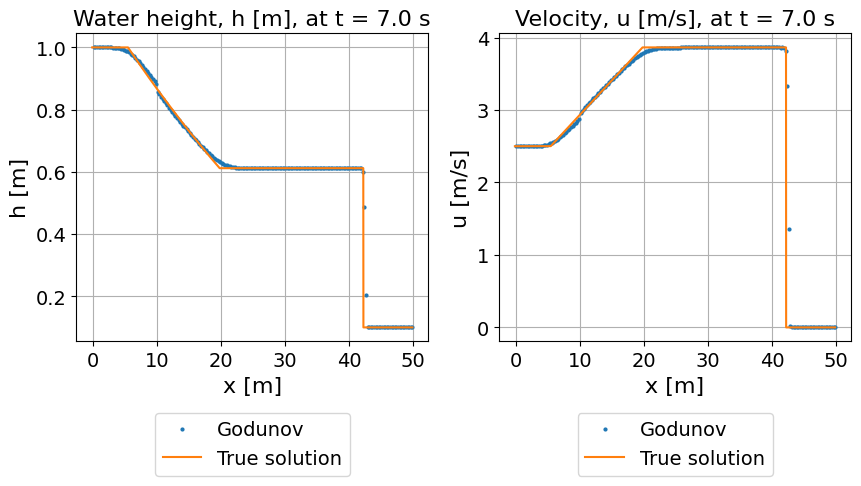

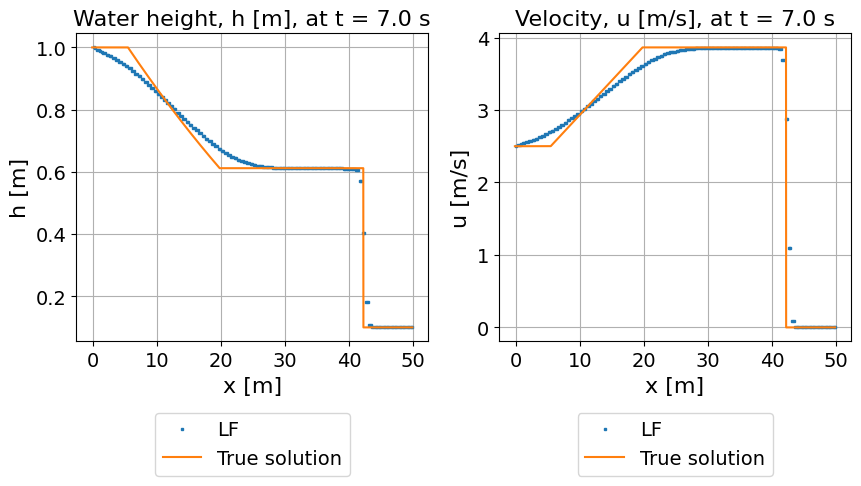

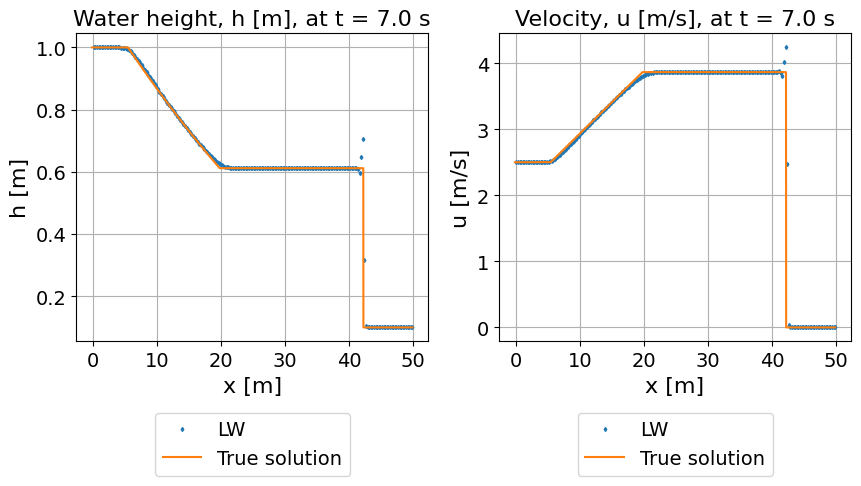

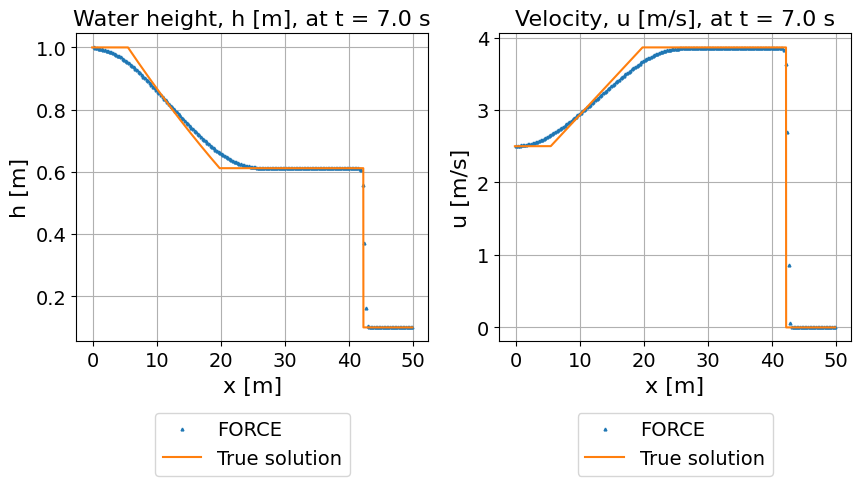

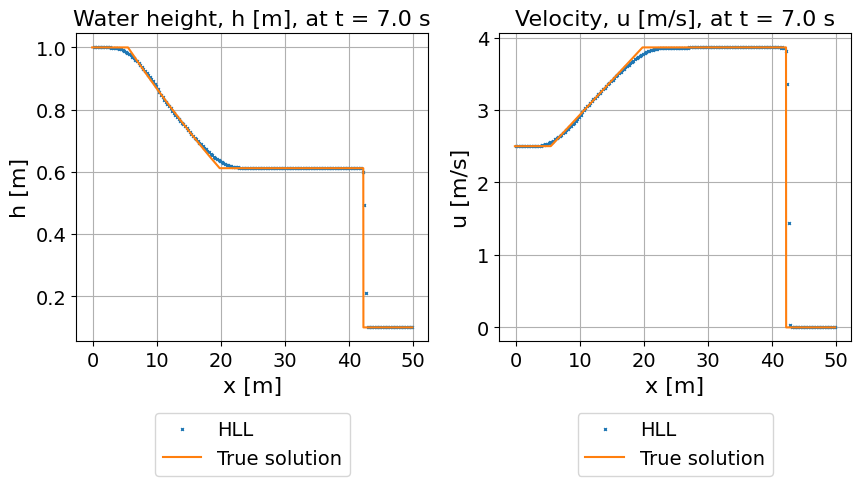

In [46]:
plot_final_data(xc, xexact, h_GOD, None, None, None, None, hexact, u_GOD, None, None, None, None, uexact, tend, save, 2, 'plots/toro_test1_final_GOD.pdf')
plot_final_data(xc, xexact, None, h_LF, None, None, None, hexact, None, u_LF, None, None, None, uexact, tend, save, 2, 'plots/toro_test1_final_LF.pdf')
plot_final_data(xc, xexact, None, None, h_LW, None, None, hexact, None, None, u_LW, None, None, uexact, tend, save, 2, 'plots/toro_test1_final_LW.pdf')
plot_final_data(xc, xexact, None, None, None, h_FORCE, None, hexact, None, None, None, u_FORCE, None, uexact, tend, save, 2, 'plots/toro_test1_final_FORCE.pdf')
plot_final_data(xc, xexact, None, None, None, None, h_HLL, hexact, None, None, None, None, u_HLL, uexact, tend, save, 2, 'plots/toro_test1_final_HLL.pdf')

## Test 2

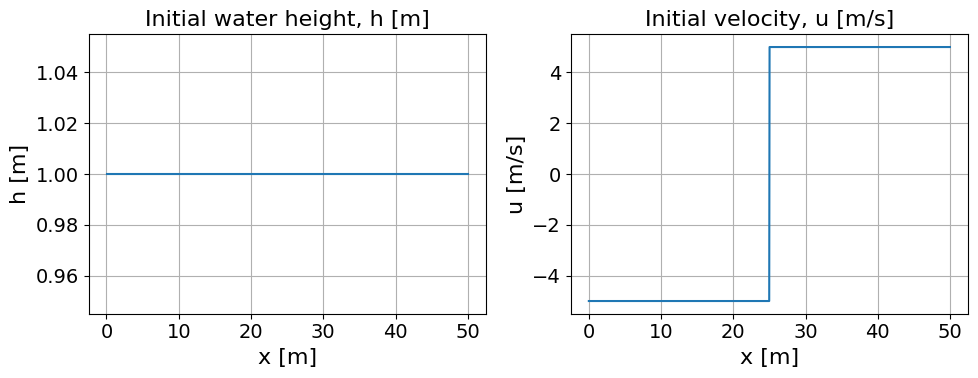

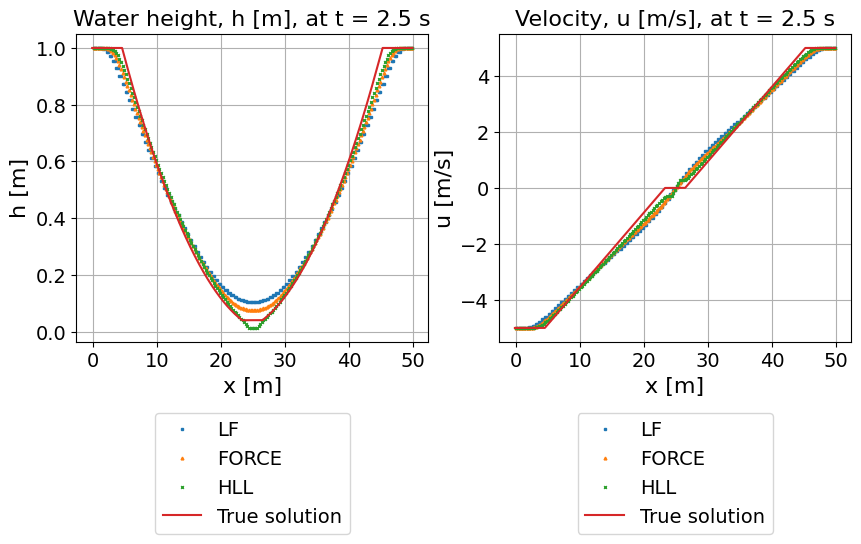

In [47]:
# Physical parameters
xL = 0
xR = 50
t = 0
tend = 2.5

# Numerical parameters
Nx = 1000 # the number of the cell-centers
dx = (xR - xL) / Nx  # distance between the mesh points
x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)

# Initial conditions
h = np.zeros(Nx)
u = np.zeros(Nx)
hL = 1.0
hR = 1.0
uL = -5.0
uR = 5.0
x0 = 25.0

# Define initial water height and velocity
h = np.where(x < x0, hL, hR)           
u = np.where(x < x0, uL, uR)

filename = 'plots/toro_test2_initial.pdf'
plot_initial_data(x, h, u, save, filename)

# Import numerical and true solution from Matlab 
mat_data = loadmat('data/torotest2flux2.mat')
xc = mat_data['xc']
h_LF = mat_data['h']
u_LF = mat_data['u']
xexact = mat_data['xexact']
hexact = mat_data['hexact']
uexact = mat_data['uexact']

# Load other numerical solutions
mat_data = loadmat('data/torotest2flux3.mat')
h_LW = mat_data['h']
u_LW = mat_data['u']

mat_data = loadmat('data/torotest2flux4.mat')
h_FORCE = mat_data['h']
u_FORCE = mat_data['u']

mat_data = loadmat('data/torotest2flux5.mat')
h_HLL = mat_data['h']
u_HLL = mat_data['u']

filename = 'plots/toro_test2_final.pdf'
plot_final_data(xc, xexact, None, h_LF, None, h_FORCE, h_HLL, hexact, None, u_LF, None, u_FORCE, u_HLL, uexact, tend, save, 2, filename)


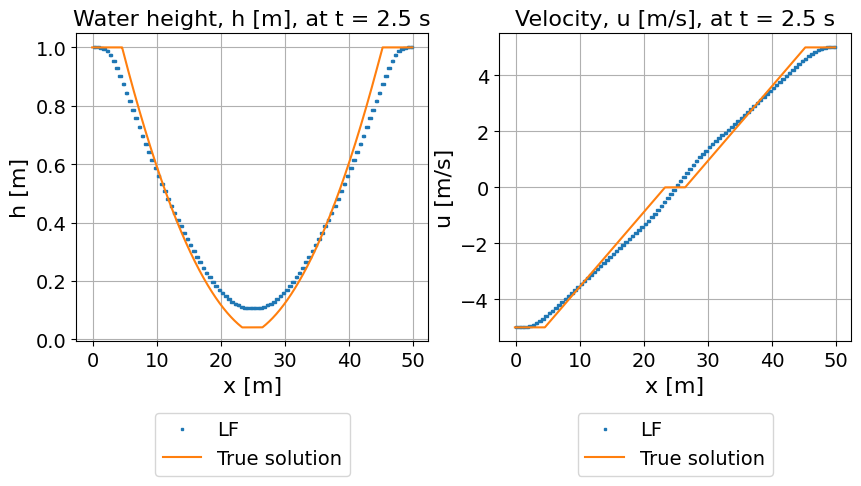

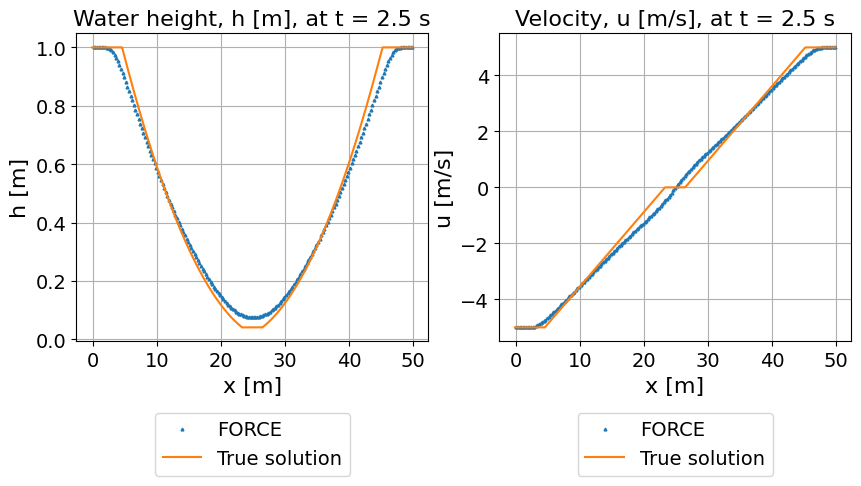

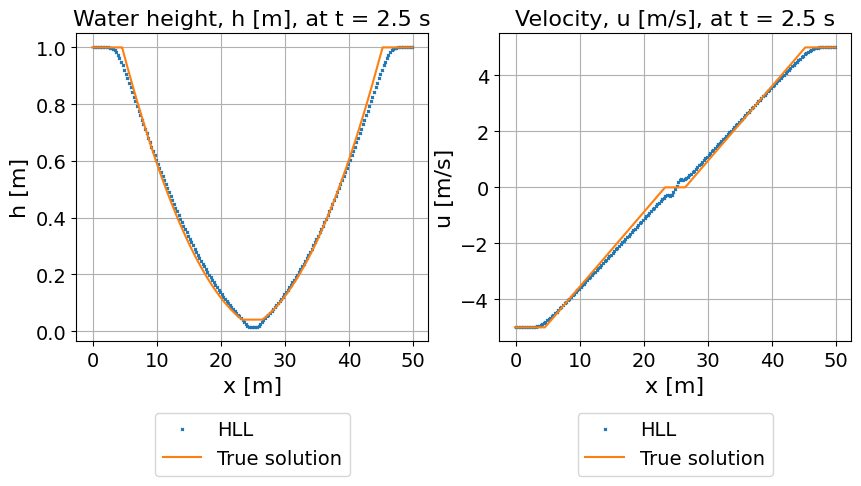

In [48]:
#plot_final_data(xc, xexact, h_GOD, None, None, None, None, hexact, u_GOD, None, None, None, None, uexact, tend, save, 2, 'plots/toro_test2_final_GOD.pdf')
plot_final_data(xc, xexact, None, h_LF, None, None, None, hexact, None, u_LF, None, None, None, uexact, tend, save, 2, 'plots/toro_test2_final_LF.pdf')
#plot_final_data(xc, xexact, None, None, h_LW, None, None, hexact, None, None, u_LW, None, None, uexact, tend, save, 2, 'plots/toro_test2_final_LW.pdf')
plot_final_data(xc, xexact, None, None, None, h_FORCE, None, hexact, None, None, None, u_FORCE, None, uexact, tend, save, 2, 'plots/toro_test2_final_FORCE.pdf')
plot_final_data(xc, xexact, None, None, None, None, h_HLL, hexact, None, None, None, None, u_HLL, uexact, tend, save, 2, 'plots/toro_test2_final_HLL.pdf')

## Test 3

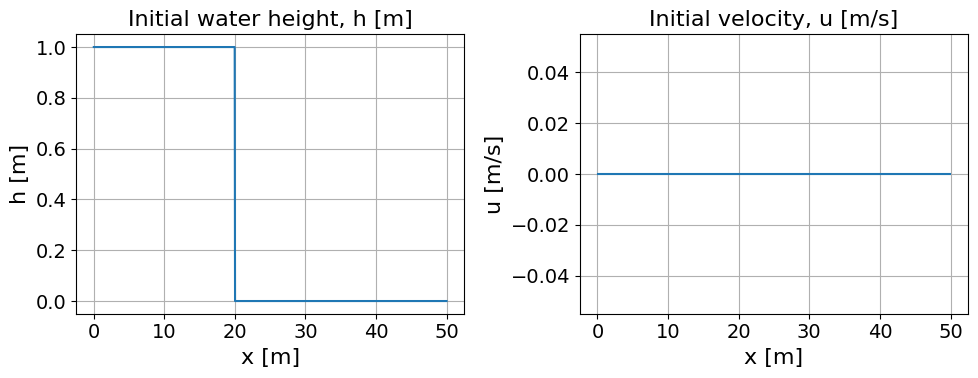

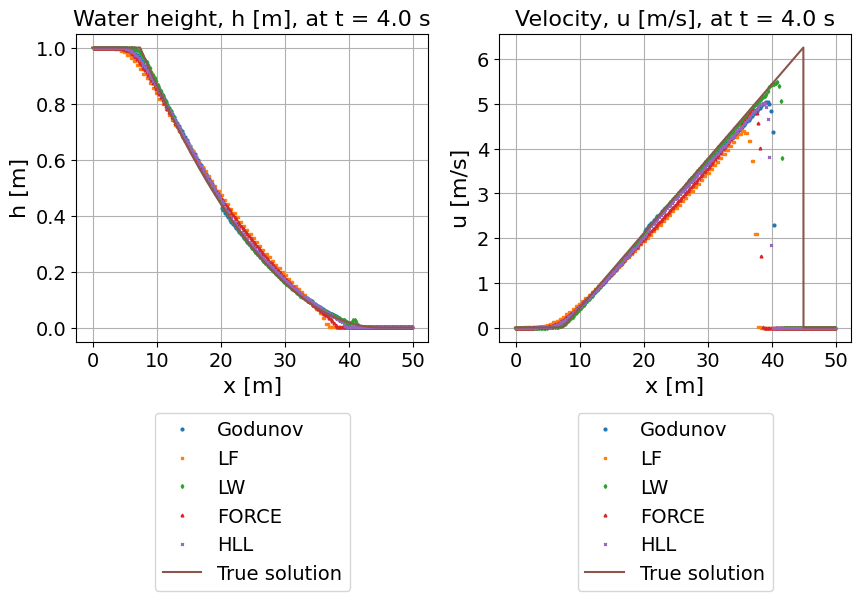

In [49]:
# Physical parameters
xL = 0
xR = 50
t = 0
tend = 4.0

# Numerical parameters
Nx = 1000  # the number of the cell-centers
dx = (xR - xL) / Nx  # distance between the mesh points
x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)

# Initial conditions
h = np.zeros(Nx)
u = np.zeros(Nx)
hL = 1.0
hR = 0.0
uL = 0.0
uR = 0.0
x0 = 20.0

# Define initial water height and velocity
h = np.where(x < x0, hL, hR)           
u = np.where(x < x0, uL, uR)

# Plot initial conditions
filename = 'plots/toro_test3_initial.pdf'
plot_initial_data(x, h, u, save, filename)

# Import numerical and true solution from Matlab 
mat_data = loadmat('data/torotest6flux1.mat')  # Load another test, which have hR = 0.0 
xexact = mat_data['xexact']
hexact = mat_data['hexact']
uexact = mat_data['uexact']

mat_data = loadmat('data/torotest3flux1.mat')
xc = mat_data['xc']
h_GOD = mat_data['h']
u_GOD = mat_data['u']

mat_data = loadmat('data/torotest3flux2.mat')
h_LF = mat_data['h']
u_LF = mat_data['u']

# Load other numerical solutions
mat_data = loadmat('data/torotest3flux3.mat')
h_LW = mat_data['h']
u_LW = mat_data['u']

mat_data = loadmat('data/torotest3flux4.mat')
h_FORCE = mat_data['h']
u_FORCE = mat_data['u']

mat_data = loadmat('data/torotest3flux5.mat')
h_HLL = mat_data['h']
u_HLL = mat_data['u']

# Plot final state
filename = 'plots/toro_test3_final.pdf'
plot_final_data(xc, xexact, h_GOD, h_LF, h_LW, h_FORCE, h_HLL, hexact, u_GOD, u_LF, u_LW, u_FORCE, u_HLL, uexact, tend, save, 2, filename)

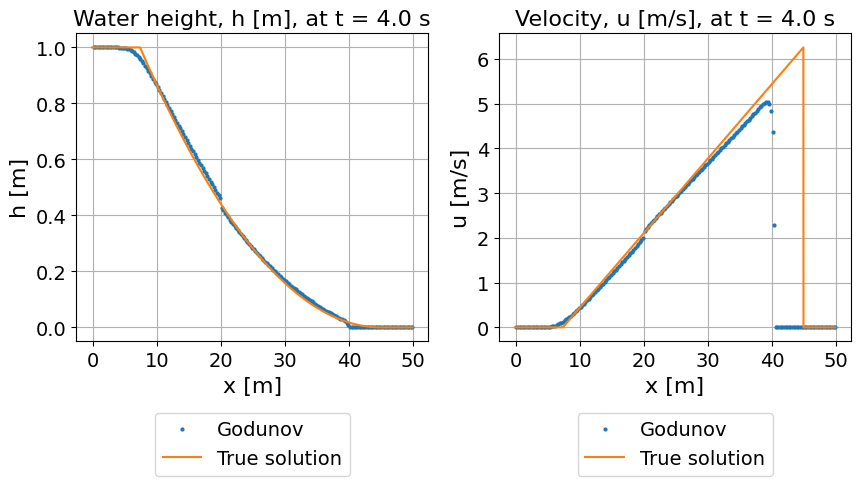

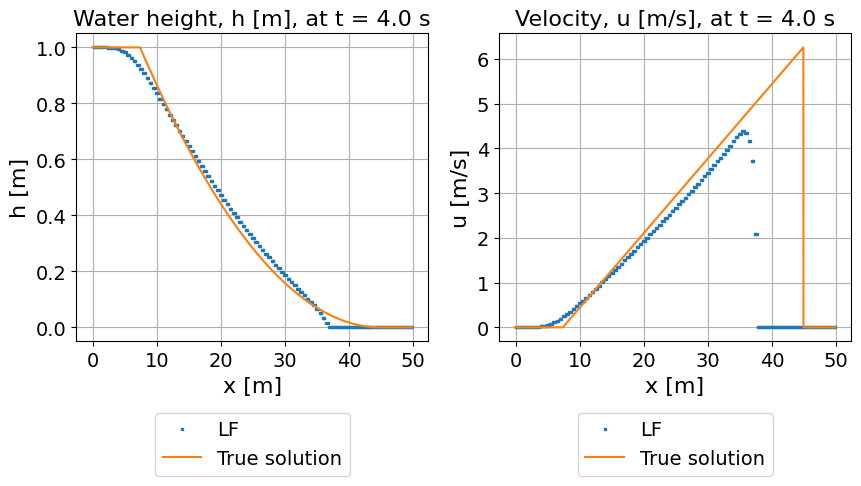

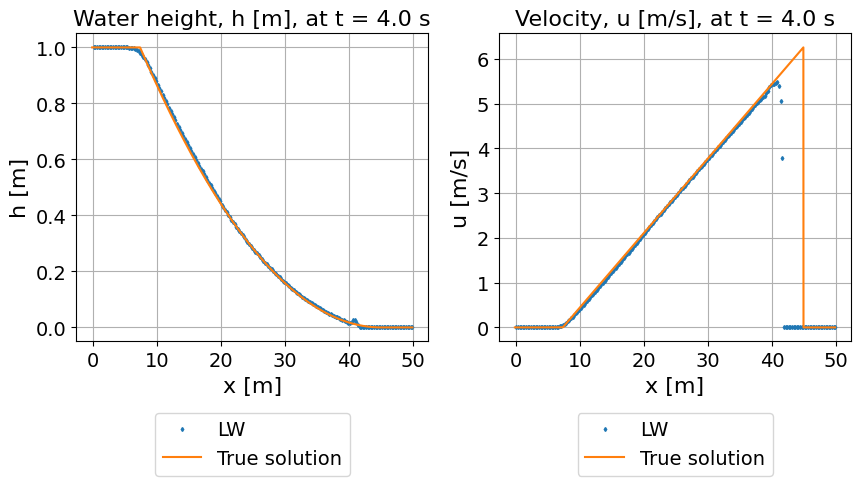

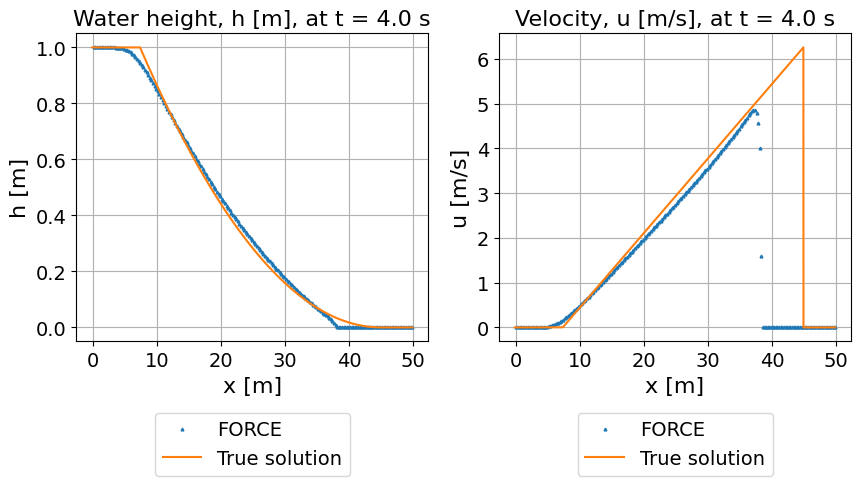

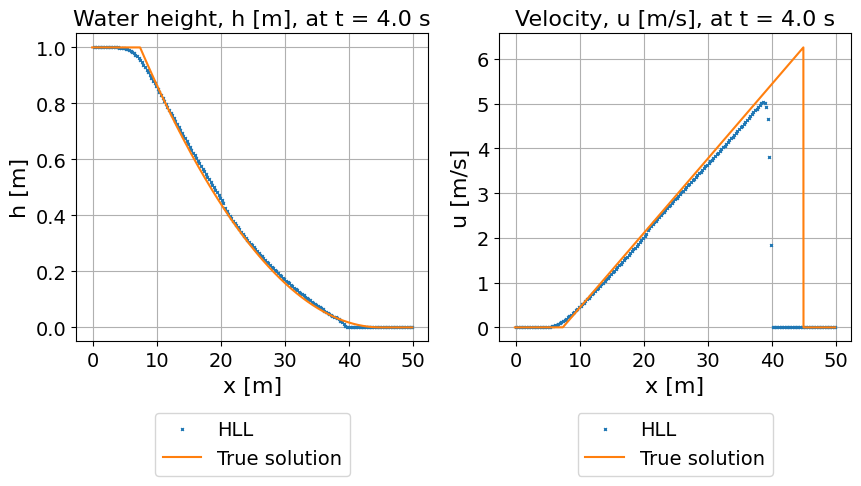

In [50]:
plot_final_data(xc, xexact, h_GOD, None, None, None, None, hexact, u_GOD, None, None, None, None, uexact, tend, save, 2, 'plots/toro_test3_final_GOD.pdf')
plot_final_data(xc, xexact, None, h_LF, None, None, None, hexact, None, u_LF, None, None, None, uexact, tend, save, 2, 'plots/toro_test3_final_LF.pdf')
plot_final_data(xc, xexact, None, None, h_LW, None, None, hexact, None, None, u_LW, None, None, uexact, tend, save, 2, 'plots/toro_test3_final_LW.pdf')
plot_final_data(xc, xexact, None, None, None, h_FORCE, None, hexact, None, None, None, u_FORCE, None, uexact, tend, save, 2, 'plots/toro_test3_final_FORCE.pdf')
plot_final_data(xc, xexact, None, None, None, None, h_HLL, hexact, None, None, None, None, u_HLL, uexact, tend, save, 2, 'plots/toro_test3_final_HLL.pdf')

## Test 4

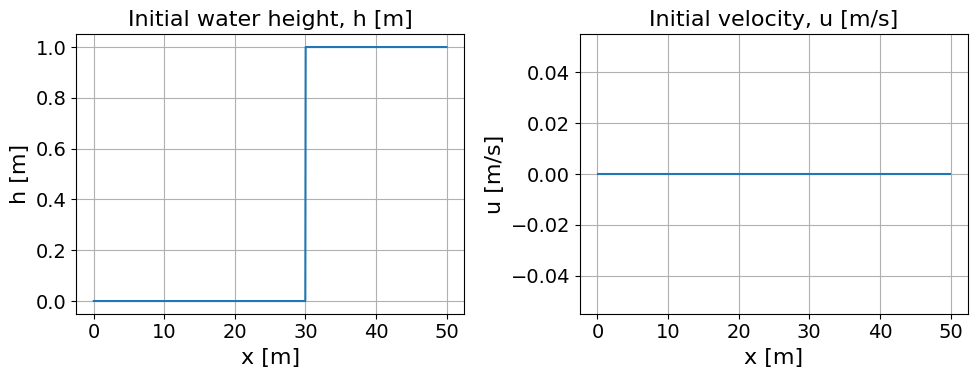

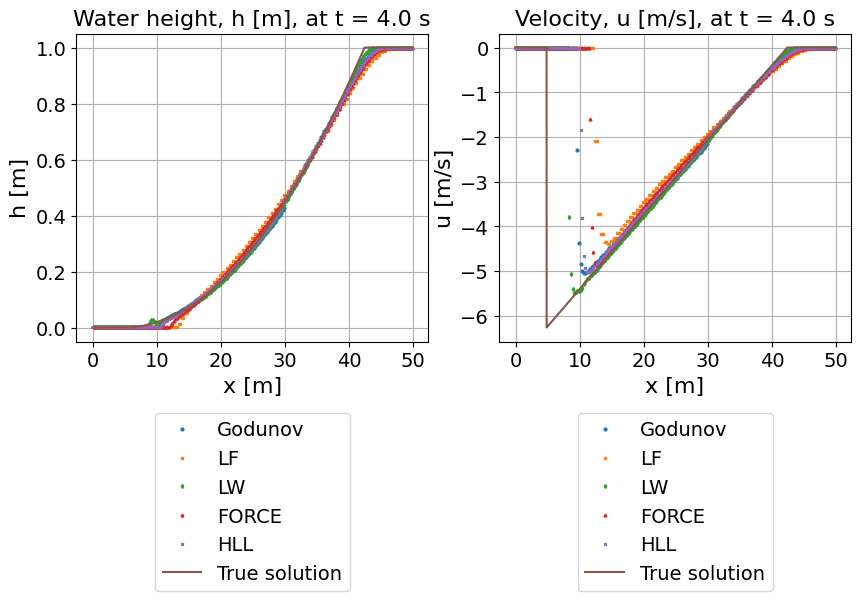

In [51]:
# Physical parameters
xL = 0
xR = 50
t = 0
tend = 4.0

# Numerical parameters
Nx = 1000  # the number of the cell-centers
dx = (xR - xL) / Nx  # distance between the mesh points
x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)

# Initial conditions
h = np.zeros(Nx)
u = np.zeros(Nx)
hL = 0.0
hR = 1.0
uL = 0.0
uR = 0.0
x0 = 30.0

# Define initial water height and velocity
h = np.where(x < x0, hL, hR)           
u = np.where(x < x0, uL, uR)

# Plot initial conditions
filename = 'plots/toro_test4_initial.pdf'
plot_initial_data(x, h, u, save, filename)

# Import numerical and true solution from Matlab - Godunov method and split upwind does not work
mat_data = loadmat('data/torotest7flux1.mat')  # Load another test, which have hR = 0.0 
xexact = mat_data['xexact']
hexact = mat_data['hexact']
uexact = mat_data['uexact']

# Load other numerical solutions
mat_data = loadmat('data/torotest4flux1.mat')
xc = mat_data['xc']
h_GOD = mat_data['h']
u_GOD = mat_data['u']

mat_data = loadmat('data/torotest4flux2.mat')
h_LF = mat_data['h']
u_LF = mat_data['u']

mat_data = loadmat('data/torotest4flux3.mat')
h_LW = mat_data['h']
u_LW = mat_data['u']

mat_data = loadmat('data/torotest4flux4.mat')
h_FORCE = mat_data['h']
u_FORCE = mat_data['u']

mat_data = loadmat('data/torotest4flux5.mat')
h_HLL = mat_data['h']
u_HLL = mat_data['u']

# Plot final state
filename = 'plots/toro_test4_final.pdf'
plot_final_data(xc, xexact, h_GOD, h_LF, h_LW, h_FORCE, h_HLL, hexact, u_GOD, u_LF, u_LW, u_FORCE, u_HLL, uexact, tend, save, 2, filename)

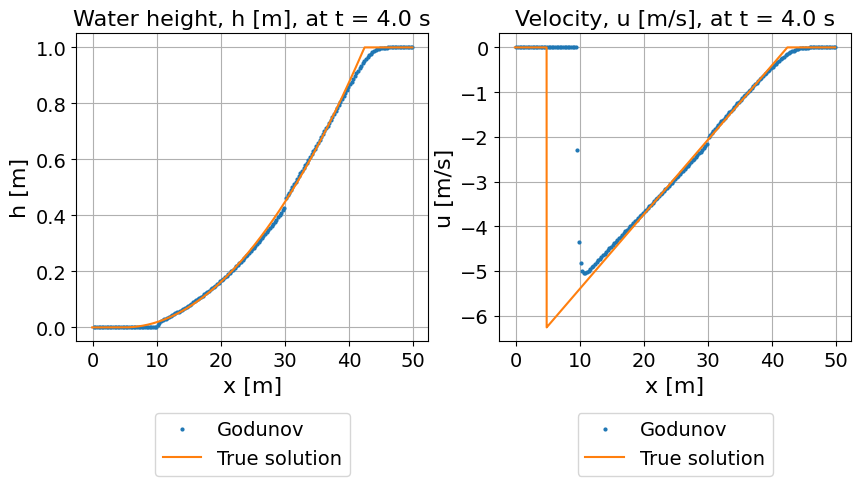

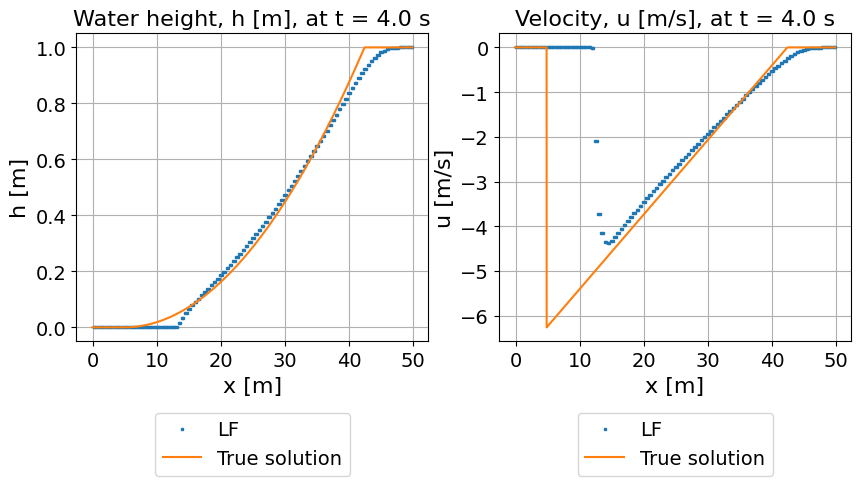

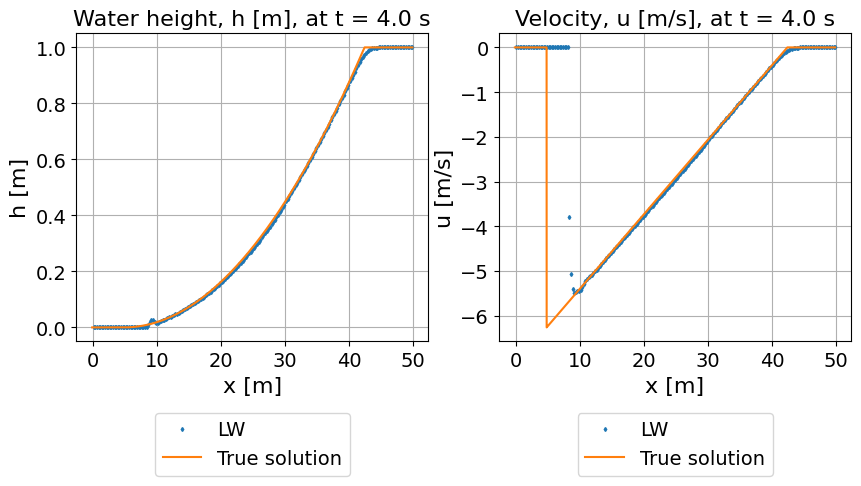

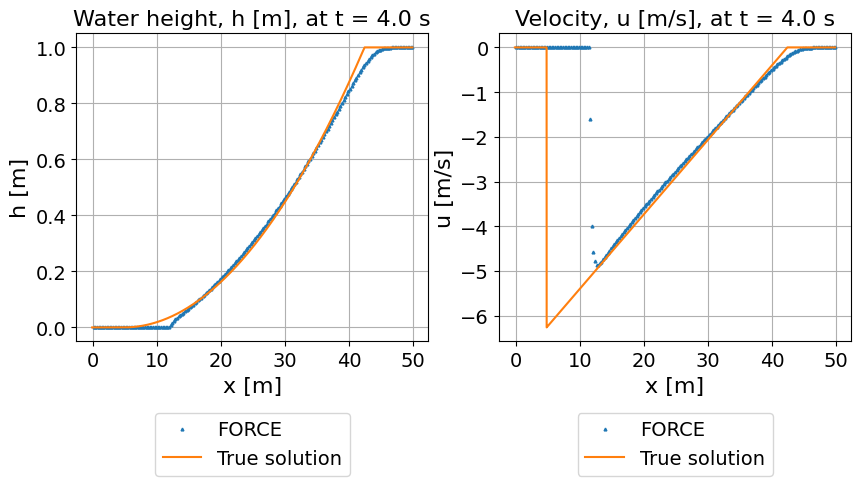

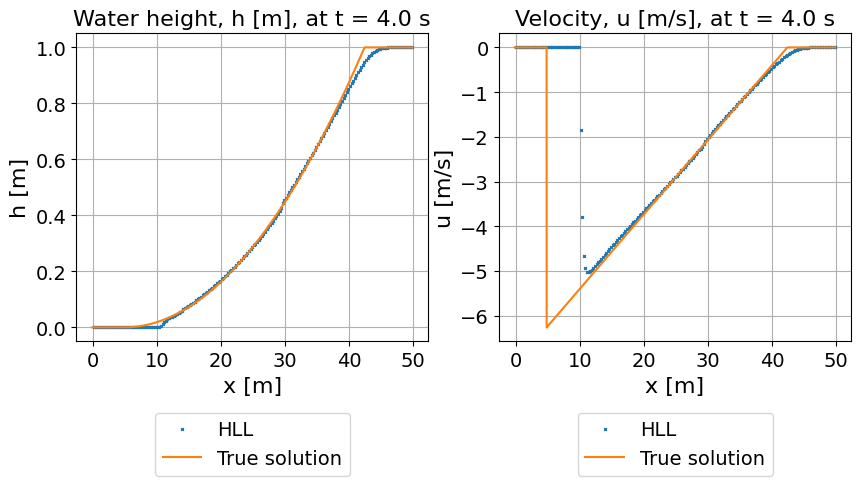

In [52]:
plot_final_data(xc, xexact, h_GOD, None, None, None, None, hexact, u_GOD, None, None, None, None, uexact, tend, save, 2, 'plots/toro_test4_final_GOD.pdf')
plot_final_data(xc, xexact, None, h_LF, None, None, None, hexact, None, u_LF, None, None, None, uexact, tend, save, 2, 'plots/toro_test4_final_LF.pdf')
plot_final_data(xc, xexact, None, None, h_LW, None, None, hexact, None, None, u_LW, None, None, uexact, tend, save, 2, 'plots/toro_test4_final_LW.pdf')
plot_final_data(xc, xexact, None, None, None, h_FORCE, None, hexact, None, None, None, u_FORCE, None, uexact, tend, save, 2, 'plots/toro_test4_final_FORCE.pdf')
plot_final_data(xc, xexact, None, None, None, None, h_HLL, hexact, None, None, None, None, u_HLL, uexact, tend, save, 2, 'plots/toro_test4_final_HLL.pdf')

## Test 5

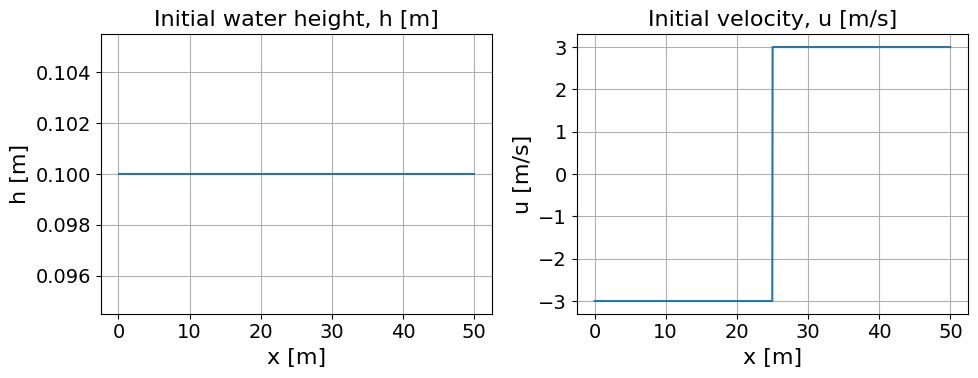

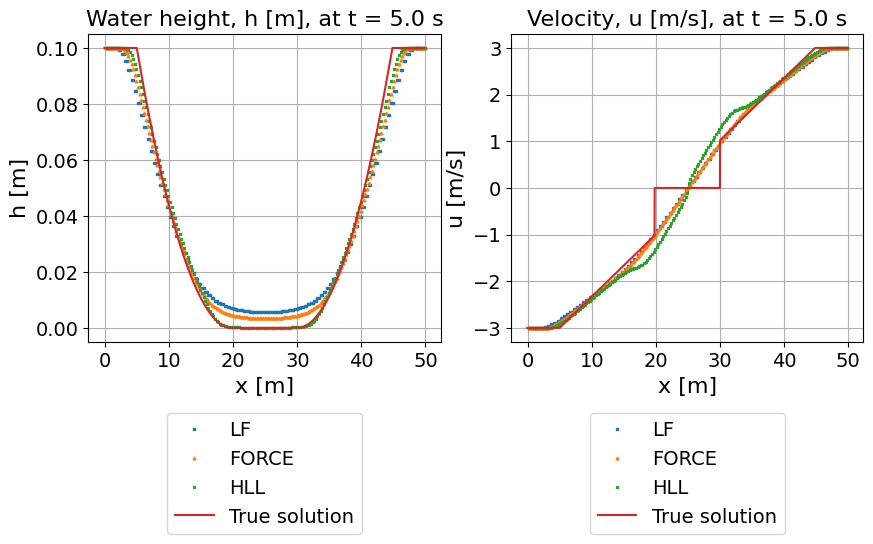

In [59]:
# Physical parameters
xL = 0
xR = 50
t = 0
tend = 5.0

# Numerical parameters
Nx = 1000 # the number of the cell-centers
dx = (xR - xL) / Nx  # distance between the mesh points
x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)

# Initial conditions
h = np.zeros(Nx)
u = np.zeros(Nx)
hL = 0.1
hR = 0.1
uL = -3.0
uR = 3.0
x0 = 25.0

# Define initial water height and velocity
h = np.where(x < x0, hL, hR)           
u = np.where(x < x0, uL, uR)

# Plot initial conditions
filename = 'plots/toro_test5_initial.pdf'
plot_initial_data(x, h, u, save, filename)

# Import numerical and true solution from Matlab - Godunov method and split upwind does not work
mat_data = loadmat('data/torotest5flux2.mat')
xc = mat_data['xc']
h_LF = mat_data['h']
u_LF = mat_data['u']
xexact = mat_data['xexact']
hexact = mat_data['hexact']
uexact = mat_data['uexact']

# Load other numerical solutions
mat_data = loadmat('data/torotest5flux3.mat')
h_LW = mat_data['h']
u_LW = mat_data['u']

mat_data = loadmat('data/torotest5flux4.mat')
h_FORCE = mat_data['h']
u_FORCE = mat_data['u']

mat_data = loadmat('data/torotest5flux5.mat')
h_HLL = mat_data['h']
u_HLL = mat_data['u']

# Plot final state
filename = 'plots/toro_test5_final.pdf'
plot_final_data(xc, xexact, None, h_LF, None, h_FORCE, h_HLL, hexact, None, u_LF, None, u_FORCE, u_HLL, uexact, tend, save, 2, filename)

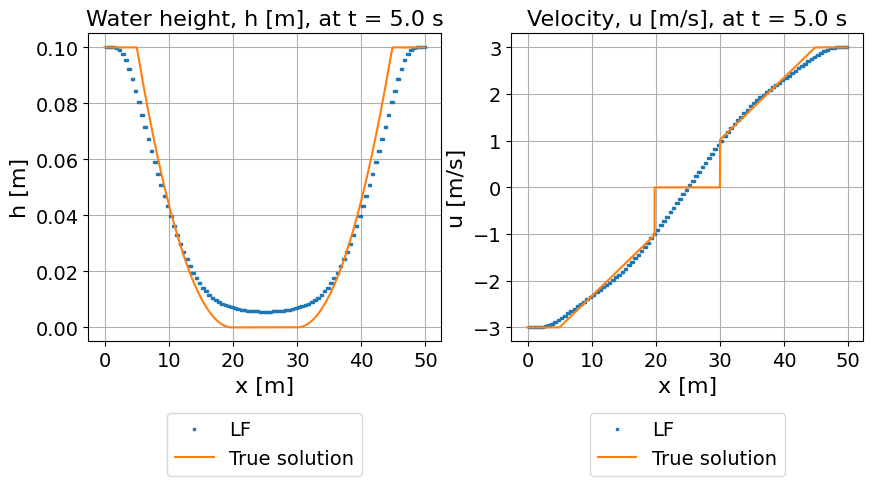

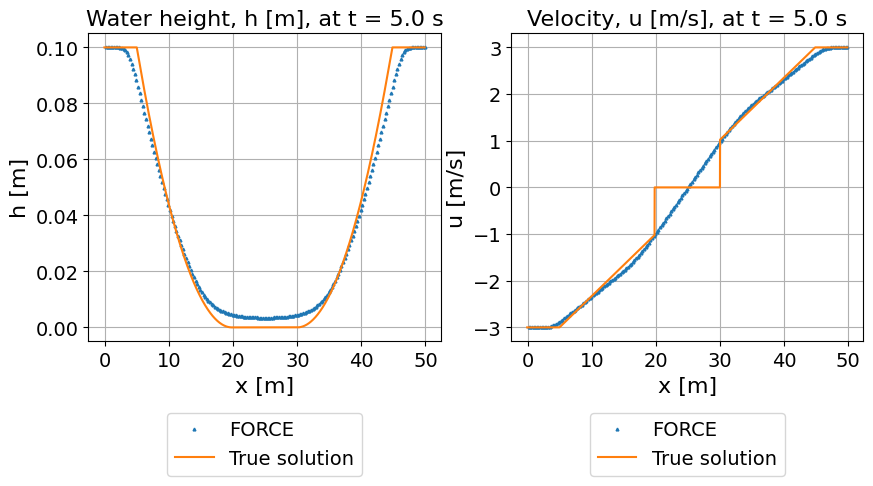

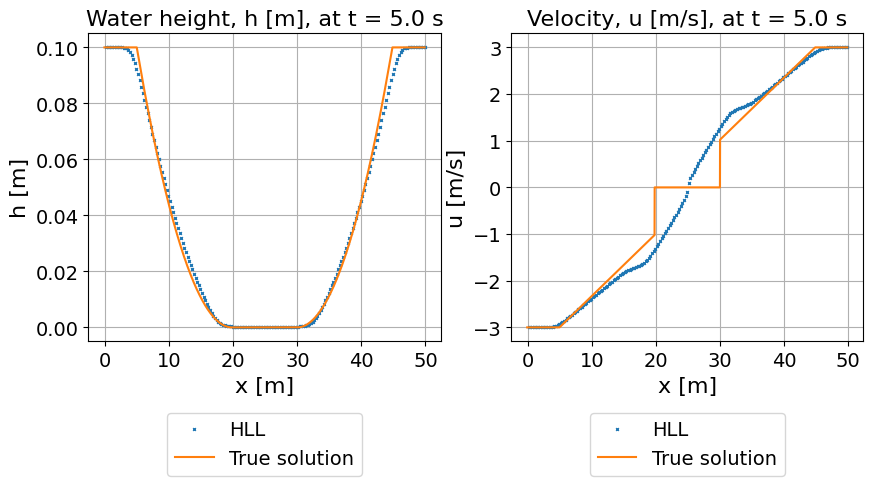

In [60]:
#plot_final_data(xc, xexact, h_GOD, None, None, None, None, hexact, u_GOD, None, None, None, None, uexact, tend, save, 2, 'plots/toro_test5_final_GOD.pdf')
plot_final_data(xc, xexact, None, h_LF, None, None, None, hexact, None, u_LF, None, None, None, uexact, tend, save, 2, 'plots/toro_test5_final_LF.pdf')
#plot_final_data(xc, xexact, None, None, h_LW, None, None, hexact, None, None, u_LW, None, None, uexact, tend, save, 2, 'plots/toro_test5_final_LW.pdf')
plot_final_data(xc, xexact, None, None, None, h_FORCE, None, hexact, None, None, None, u_FORCE, None, uexact, tend, save, 2, 'plots/toro_test5_final_FORCE.pdf')
plot_final_data(xc, xexact, None, None, None, None, h_HLL, hexact, None, None, None, None, u_HLL, uexact, tend, save, 2, 'plots/toro_test5_final_HLL.pdf')

# 1D LSWE on a sphere

In [148]:
sigma = 2

# Construct the file path dynamically
file_path = rf'C:\Users\Matteo\Shallow-Water-Equations\dataFNO\linear-SWE-sphere-1d_sigma={sigma},T=1.h5'

# Load data
with h5py.File(file_path, 'r') as file:
    for key in file.keys():
        print(key)
        # Check if each key is a dataset or a group
        item = file[key]
        if isinstance(item, h5py.Group):
            print(f"  '{key}' is a group containing:")
            for sub_key in item.keys():
                if sub_key.startswith("__"):
                    continue
                print(f"    {sub_key}")
        elif isinstance(item, h5py.Dataset):
            print(f" '{key}' is a dataset with shape {item.shape} and dtype {item.dtype}")

    h_all = np.array(file['data_0']['h_storage'])
    t_all = np.array(file['data_0']['t_storage'])
    theta_all = np.array(file['data_0']['theta'])
    theta_all = theta_all[:,:-1]

print(f'Loaded h_all with shape {h_all.shape}')
print(f'Loaded t_all with shape {t_all.shape}')
print(f'Loaded theta_all with shape {theta_all.shape}')

data_0
  'data_0' is a group containing:
    h_storage
    t_storage
    theta
Loaded h_all with shape (402, 500)
Loaded t_all with shape (402, 1)
Loaded theta_all with shape (1, 500)


In [170]:
def plot_1d_lswe_time_steps_sphere(h_all, t_all, theta, indices, save=False, figname='plots/1D_LSWE_sphere_time_steps'):

    r = 1
    # Create circular coordinates
    x = np.cos(theta)
    y = np.sin(theta)

    plt.figure(figsize=(15, 5))

    for i, idx in enumerate(indices):
        plt.subplot(1, 3, i+1)
        plt.plot( (r + h_all[idx])*x, -(r  + h_all[idx])*y)
        plt.plot(x, y)
        plt.xlabel('x [m]')
        plt.ylabel('y [m]')
        plt.grid()
        plt.title(f'Water height, h[m], at t = {t_all[idx][0]:.2f} s')
        plt.axis('equal')

    plt.tight_layout()

    if save:
        plt.savefig(figname, format='pdf', bbox_inches='tight')

    plt.show()


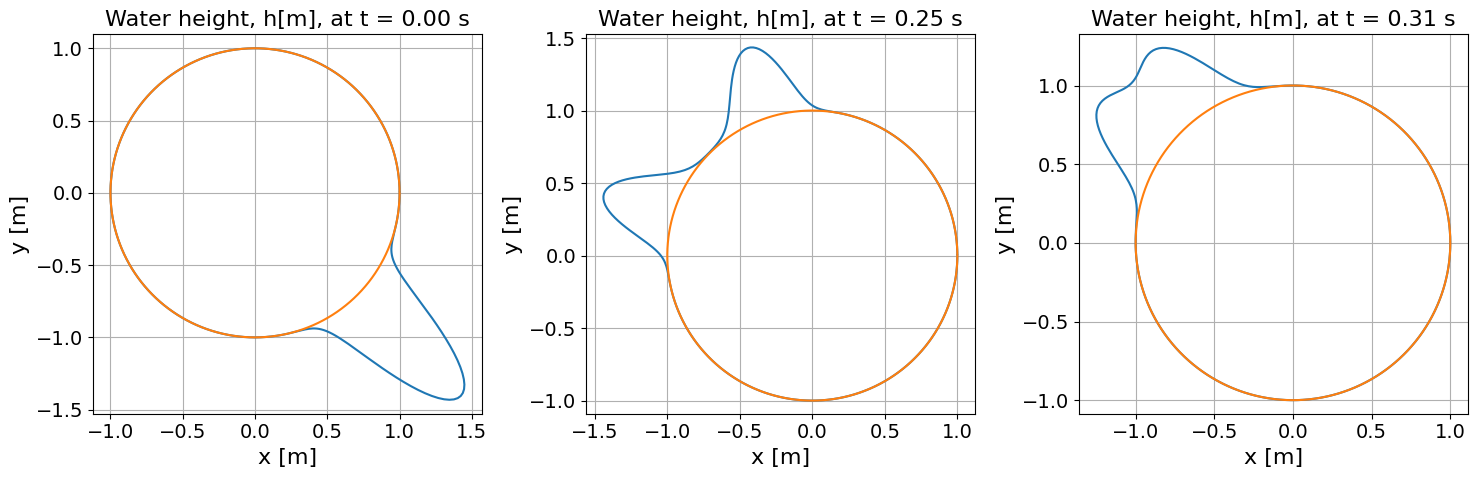

In [190]:
indices = [0, 100, 125]
plot_1d_lswe_time_steps_sphere(h_all, t_all, theta_all[0,:], indices, save=1, figname='plots/1D_LSWE_sphere_time_steps.pdf')

### Make animation

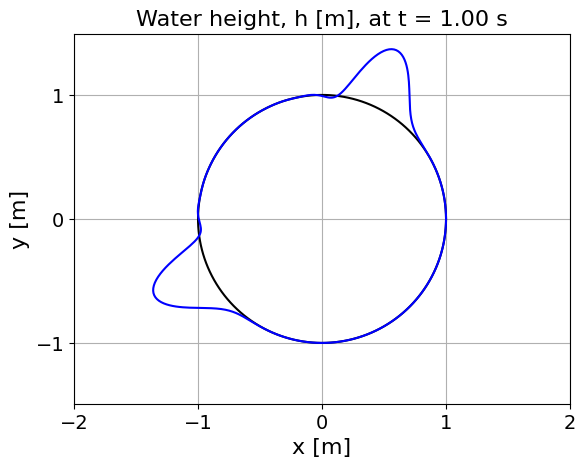

In [188]:
# Create animation for 1D LSWE
def animate_1d_lswe_sphere(h_all, t_all, theta, save=False, figname='animations/1D_LSWE_sphere_animation'):
    r = 1  # Radius of the sphere

    # Circular coordinates
    x = np.cos(theta)
    y = np.sin(theta)

    # Set up the figure
    fig, ax = plt.subplots()
    ax.set_aspect('equal', adjustable='datalim')
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.grid()

    # Set the limits of the plot
    max_r = r + np.max(h_all)
    ax.set_xlim(-max_r, max_r)
    ax.set_ylim(-max_r, max_r)
    ticks = np.arange(-2,3,1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    # Initial plot elements
    base_circle, = ax.plot(x, y, label='Sphere base', color='black')
    height_line, = ax.plot([], [], label='Height profile', color='blue')
    title = ax.set_title('')

    # Update function for animation
    def update(frame):
        h_frame = h_all[frame]  # Current water height
        height_line.set_data((r + h_frame) * x, -(r + h_frame) * y)
        title.set_text(f'Water height, h [m], at t = {t_all[frame][0]:.2f} s')
        return height_line, title

    # Create animation
    ani = animation.FuncAnimation(fig, update, frames=len(h_all), interval=50, blit=True)

    # Save the animation
    if save:
        dpi = 200
        ani.save(f'{figname}.gif', writer='pillow', dpi=dpi)
        #ani.save(f'{figname}.html', writer='html')

    # Show the animation
    plt.show()

# Example usage:
animate_1d_lswe_sphere(h_all, t_all, theta_all[0,:], save=True, figname='animations/1D_LSWE_sphere_17012025')


### Make QR code for animation


In [2]:
if 0:    
    import qrcode

    # URL of your HTML page with the GIF
    url = 'https://github.com/MelissaJessen/Shallow-Water-Equations-Animations/blob/main/1D_LSWE_sphere_17012025.gif'

    # Generate QR code
    qr = qrcode.QRCode(
        version=1,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=10,
        border=4,
    )

    # Add the URL to the QR code
    qr.add_data(url)
    qr.make(fit=True)

    # Create an image from the QR Code instance
    img = qr.make_image(fill_color="black", back_color="white")

    # Save the QR code
    img.save('QR/1D_LSWE_sphere_17012025.gif_qr.png')



# 2D Dam break problem

### Functions
The MUSCL-Hancock scheme for the 2D SWE with the Rusanov numerical flux.

### Idealised 2D dam break

In [2]:
# Initialize
save_results = 0
save_plots = 0
N = 64

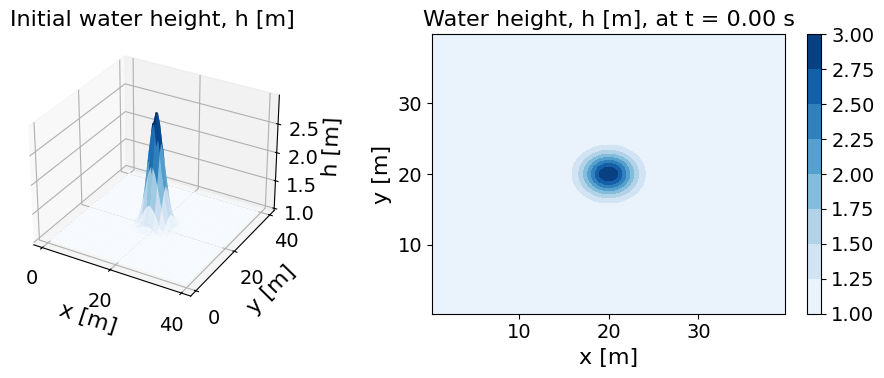

In [6]:
# Global constants
g = 9.81  # gravity
Nx = N
Ny = Nx
xL, xR = 0, 40
yL, yR = 0, 40
t = 0
tend = 20
CFL = 0.9

dx = (xR - xL) / Nx
dy = (yR - yL) / Ny

x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)
y = np.linspace(yL + dy / 2, yR - dy / 2, Ny)

# Center
xc = 20
yc = 20

# Radius
R = 2.5

# Initial conditions for the water height
Q = np.zeros((3, Nx, Ny))
Qnew = np.copy(Q)

# Define initial condition
ic = 2

if ic == 1:
    for i in range(Nx):
        for j in range(Ny):
            r = np.sqrt((x[i] - xc)**2 + (y[j] - yc)**2)
            if r < R:
                Q[0, i, j] = 2.5
            else:
                Q[0, i, j] = 0.5

# Initial condition Gauss function
sigma = 2
if ic == 2:
    for i in range(Nx):
        for j in range(Ny):
            Q[0, i, j] = 1.0 + 2 * np.exp(-((x[i] - xc)**2 + (y[j] - yc)**2) / (2 * sigma**2))

cmap = 'Blues'
# Plot the initial data in 3d and in contour
fig = plt.figure(figsize=(10, 4))

# 3D Surface plot on the first subplot
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x, y)
ax1.plot_surface(X, Y, Q[0, :, :], cmap=cmap)
ax1.set_title(f'Initial water height, h [m]')
ax1.set_xlabel('x [m]')
ax1.set_ylabel('y [m]')
ax1.set_zlabel('h [m]')

# Contour plot on the second subplot
ax2 = fig.add_subplot(122)
contour = ax2.contourf(X, Y, Q[0, :, :], cmap=cmap)
fig.colorbar(contour, ax=ax2)
ax2.set_title(f'Water height, h [m], at t = {t:.2f} s')
ax2.set_xlabel('x [m]')
ax2.set_ylabel('y [m]')

# Show the combined plot
plt.tight_layout()
plt.show()

In [8]:
# Start timer
start_time = time.time()

#Q_all, t_all = solve_2D_SWE_FVM(Q, Qnew, t, tend, CFL, dx, dy, Nx, Ny)
Q_all, t_all = solve_2D_SWE_FVM_constant_dt(Q, Qnew, t, tend, CFL, dx, dy, Nx, Ny)

# End timer
end_time = time.time()

# Print the time taken
elapsed_time = end_time - start_time
print(f'Time taken: {elapsed_time:.2f} seconds')

# Save the training time
# Specify folder path (create the folder if it doesn't exist)
folder_path = 'C:/Users/Matteo/Shallow-Water-Equations/saved_results'
os.makedirs(folder_path, exist_ok=True)  # Create the folder if it doesn't exist

# Save the training time
if save_results:
    file_path = os.path.join(folder_path, f'2D_FVM_N={Nx}_time_{tend}.txt')
    with open(file_path, 'w') as f:
        f.write(f"{elapsed_time:.2f}") # Save with 2 decimals

# Save as .h5 file
if 0:
    filename = f'dataFNO/toro2D_N={Nx}_t={tend}_constant_dt.h5'
    with h5py.File(filename, 'w') as file:
        file.create_dataset('Q_all', data=Q_all)
        file.create_dataset('t_all', data=t_all)
        file.create_dataset('x', data=x)
        file.create_dataset('y', data=y)
    print(f'Data saved to {filename}')

t = 0.025
t = 0.050
t = 0.075
t = 0.100
t = 0.125
t = 0.150
t = 0.175
t = 0.200
t = 0.225
t = 0.250
t = 0.275
t = 0.300
t = 0.325
t = 0.350
t = 0.375
t = 0.400
t = 0.425
t = 0.450
t = 0.475
t = 0.500
t = 0.525
t = 0.550
t = 0.575
t = 0.600
t = 0.625
t = 0.650
t = 0.675
t = 0.700
t = 0.725
t = 0.750
t = 0.775
t = 0.800
t = 0.825
t = 0.850
t = 0.875
t = 0.900
t = 0.925
t = 0.950
t = 0.975
t = 1.000
t = 1.025
t = 1.050
t = 1.075
t = 1.100
t = 1.125
t = 1.150
t = 1.175
t = 1.200
t = 1.225
t = 1.250
t = 1.275
t = 1.300
t = 1.325
t = 1.350
t = 1.375
t = 1.400
t = 1.425
t = 1.450
t = 1.475
t = 1.500
t = 1.525
t = 1.550
t = 1.575
t = 1.600
t = 1.625
t = 1.650
t = 1.675
t = 1.700
t = 1.725
t = 1.750
t = 1.775
t = 1.800
t = 1.825
t = 1.850
t = 1.875
t = 1.900
t = 1.925
t = 1.950
t = 1.975
t = 2.000
t = 2.025
t = 2.050
t = 2.075
t = 2.100
t = 2.125
t = 2.150
t = 2.175
t = 2.200
t = 2.225
t = 2.250
t = 2.275
t = 2.300
t = 2.325
t = 2.350
t = 2.375
t = 2.400
t = 2.425
t = 2.450
t = 2.475
t = 2.500


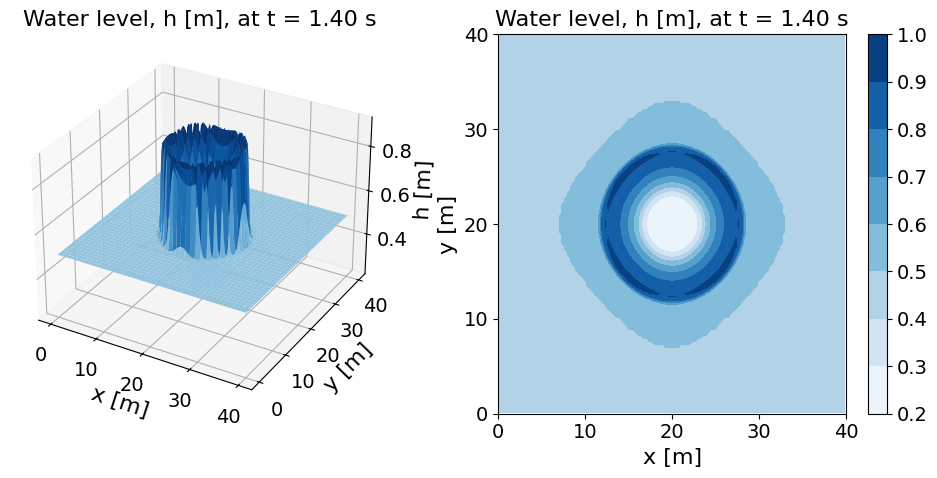

In [127]:
save = 0

# Prepare grid
X, Y = np.meshgrid(x, y)

from matplotlib import gridspec

fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 2])  # Adjust width ratios: [2, 1] makes the first plot twice as wide as the second

x_ticks = np.arange(0,50,10)  # Specify spacing dx
y_ticks = x_ticks  # Specify spacing dy

# First plot (3D)
ax1 = fig.add_subplot(gs[0], projection='3d')
surf = ax1.plot_surface(X, Y, Q_all[-1][0, :, :], cmap=cmap)
ax1.set_title(f'Water level, h [m], at t = {tend:.2f} s')
ax1.set_xlabel('x [m]')
ax1.set_ylabel('y [m]')
ax1.set_zlabel('h [m]')
# fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=5)

# Second plot (Contour)
ax2 = fig.add_subplot(gs[1])
contour = ax2.contourf(X, Y, Q_all[-1][0, :, :], cmap=cmap)
fig.colorbar(contour, ax=ax2)
ax2.set_title(f'Water level, h [m], at t = {tend:.2f} s')
ax2.set_xlabel('x [m]')
ax2.set_ylabel('y [m]')
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)
#ax2.set_aspect('equal')
plt.tight_layout()

# Save figure
if save:
    filename = f'plots/toro2D_t={tend}.pdf'
    plt.savefig(filename, format='pdf')

plt.show()

### Make animation

In [47]:
n = len(Q_all)

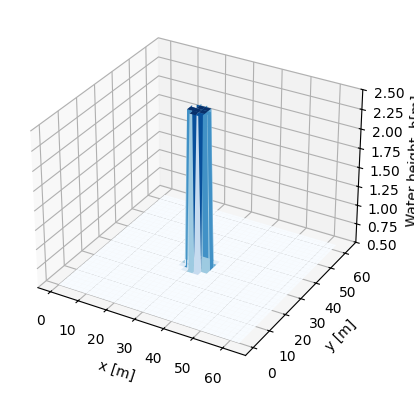

In [48]:
# Make animation
if 0:
    # Assuming Nx and Ny are the dimensions of your data
    Nx, Ny = Q_all[0][0].shape
    x = np.linspace(0, Nx-1, Nx)
    y = np.linspace(0, Ny-1, Ny)
    X, Y = np.meshgrid(x, y)

    # Set up the figure and 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_zlim(np.min(Q_all[0][0]), np.max(Q_all[0][0]))
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.set_zlabel('Water height, h[m]')

    # Initial surface plot
    surf = ax.plot_surface(X, Y, Q_all[0][0], cmap=cmap)

    # Update function for the animation
    def update(frame):
        ax.clear()
        ax.set_zlim(np.min(Q_all[0][0]), np.max(Q_all[0][0]))
        ax.set_xlabel('x [m]')
        ax.set_ylabel('y [m]')
        ax.set_zlabel('Water height, h[m]')
        ax.set_title(f'Water height, h[m], at time step {frame}/{n}')
        surf = ax.plot_surface(X, Y, Q_all[frame][0], cmap=cmap)
        return [surf]

    # Create the animation
    ani = animation.FuncAnimation(fig, update, frames=len(Q_all), interval=100)

    # Display the animation
    plt.show()

    # Save the animation
    ani.save(f'animations/toro2D_dambreak_FVM_17012025_N={Nx}_t={tend}.html', writer='html')
    dpi = 200
    ani.save(f'animations/toro2D_dambreak_FVM_17012025_N={Nx}_t={tend}.gif', writer='pillow', dpi=dpi)


### Make QR code for animation

In [50]:
if 0:    
    import qrcode

    # URL of your HTML page with the GIF
    url = 'https://github.com/MelissaJessen/Shallow-Water-Equations-Animations/blob/main/toro2D_dambreak_FVM_17012025_N%3D64_t%3D10.gif'

    # Generate QR code
    qr = qrcode.QRCode(
        version=1,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=10,
        border=4,
    )

    # Add the URL to the QR code
    qr.add_data(url)
    qr.make(fit=True)

    # Create an image from the QR Code instance
    img = qr.make_image(fill_color="black", back_color="white")

    # Save the QR code
    img.save('QR/toro2D_dambreak_FVM_17012025_N=64_t=10_qr.png')



### Scalability 

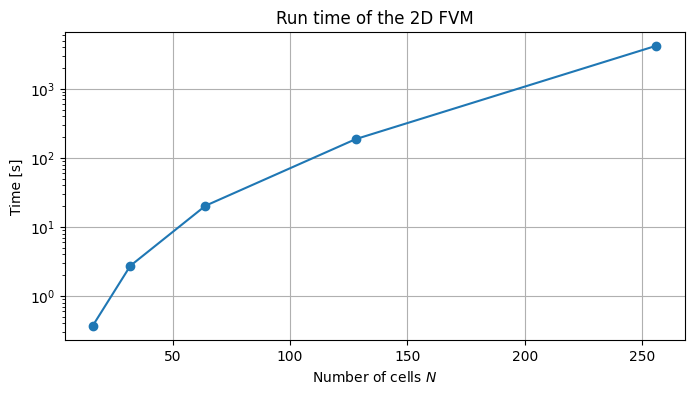

In [25]:
# Scalability issues
times = [(16, 0.37), (32, 2.73), (64, 20.23), (128, 186.83), (256, 4205.45)]

# Plot the scalability
plt.figure(figsize=(8, 4))
plt.plot(*zip(*times), marker='o')
plt.grid()
plt.xlabel('Number of cells $N$')
plt.ylabel('Time [s]')
plt.title('Run time of the 2D FVM')
plt.yscale('log')

if save_plots:
    plt.savefig('plots/scalability_FVM_2D.pdf', format='pdf')

plt.show()